In [1]:
from config_run import *

transit_duration = 2.67*u.h
exptime = 200*u.s
system_obj = init_simulation('Sorg20X')

py.warnings - WARNING: /net/lem/data1/grasser/conda_envs/py_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Kp = 49.599 km / s
90 exposures of 120.0 s each = 10800.0 s
80 exposures in transit = 9600.0 s
Transit duration = 9612.0 s


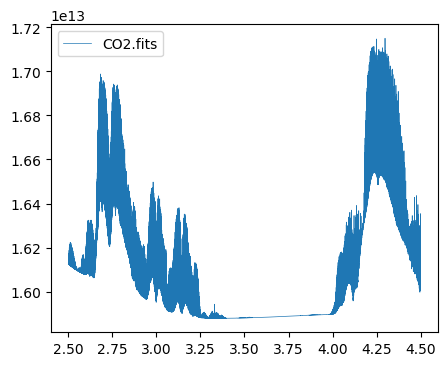

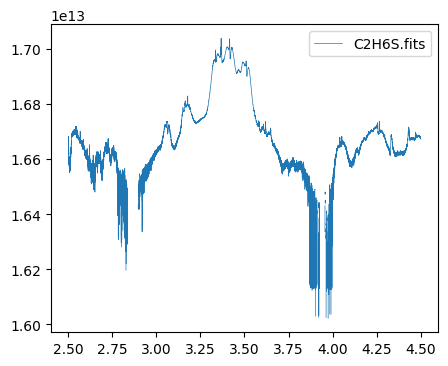

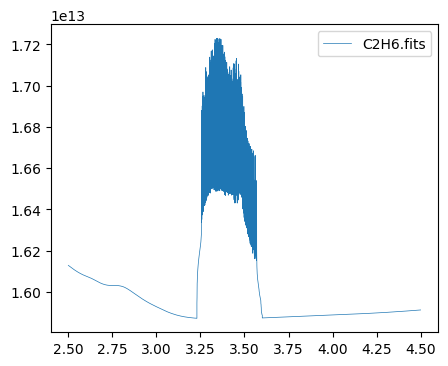

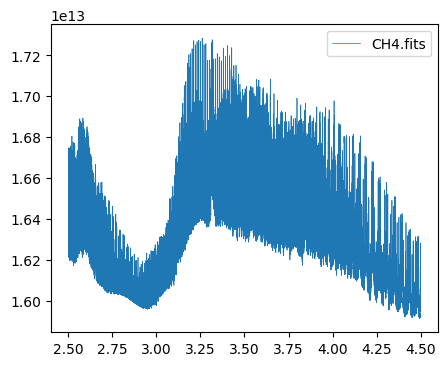

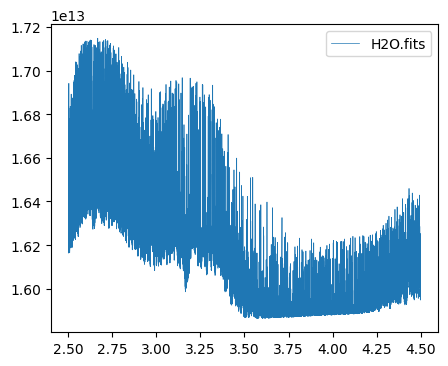

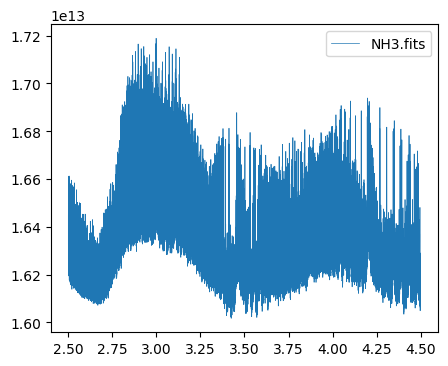

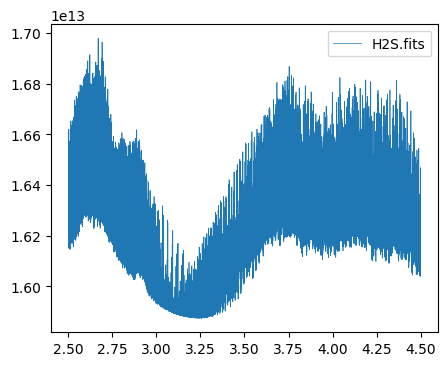

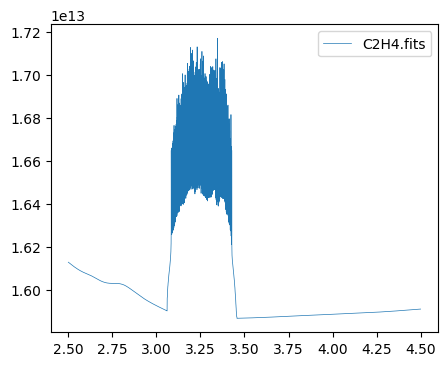

In [26]:
import pathlib
from astropy.table import QTable
import matplotlib.pyplot as plt

spec_path = pathlib.Path('/net/lem/data1/grasser/METIS_transmission/METIS_transmission/Sorg20X/pRT_spectra')
specs = [f for f in spec_path.iterdir()]

for spec in specs:
    tbl = QTable.read(spec)
    wl = tbl['wavelength'] # in um
    fl = tbl['flux'] # transit radius in um
    if spec.name=='planet_spectrum.fits':
        pass
        #plt.plot(wl,fl,label=spec.name,c='k',lw=0.5,order=10)
    else:
        plt.figure(figsize=(5,4),dpi=100)
        plt.plot(wl,fl,label=spec.name,lw=0.5)
        plt.legend()
        plt.show()



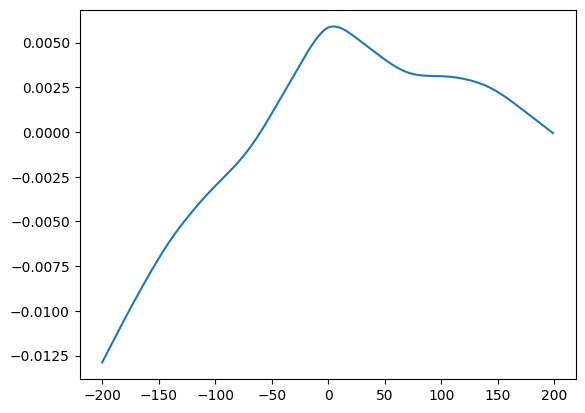

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.interpolate import interp1d
from pRT_model import *

def remove_continuum(wave, spec, err=None, poly_order=3, get_cont=False):

    return_only_flux = False
    if err is None:
        return_only_flux = True
        err = np.ones_like(spec)

    if np.ndim(spec) == 1:
        nans = np.isnan(spec)
        continuum = np.poly1d(np.polyfit(wave[~nans],spec[~nans],poly_order))(wave)
        flux_contrem = spec / continuum
        err_contrem = err / continuum
        if return_only_flux:
            return flux_contrem
        return (flux_contrem, err_contrem, continuum) if get_cont else (flux_contrem, err_contrem)

spec_path = pathlib.Path('/net/lem/data1/grasser/METIS_transmission/METIS_transmission/Sorg20X/pRT_spectra')
DMS_spec = f'{spec_path}/C2H6S.fits'
tbl = QTable.read(DMS_spec)
temp_wl = tbl['wavelength'].value # in um
temp_fl = tbl['flux'].value # transit radius in um

mask = (temp_wl<3.45)&(temp_wl>3.15)
wl = temp_wl[mask]
fl = temp_fl[mask]
fl = remove_continuum(wl,fl)

RVs=np.arange(-200,200,1) # km/s
beta=1.0-RVs/const.c.to('km/s').value

wl_shift=wl[:, np.newaxis]*beta[np.newaxis, :]
template_shift=interp1d(temp_wl,temp_fl)(wl_shift) #interpolate template onto shifted wl-grid
# do same for template as for spectra, remove cont with polydeg=3
template_shift=np.array([remove_continuum(wav,temp) for wav,temp in zip(wl_shift.T,template_shift.T)])
template_shift = template_shift - np.mean(template_shift, axis=0) # simplified continuum removal
CCF = (fl).dot(template_shift.T) #error weighted

plt.plot(RVs,CCF)

(-100.0, 100.0)

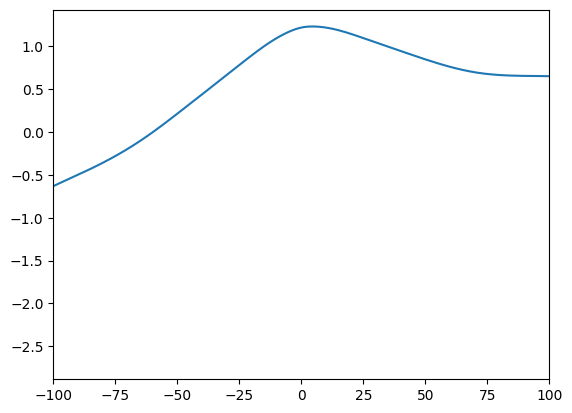

In [33]:
noise=np.std(CCF[np.abs(RVs)>30])
plt.plot(RVs,CCF/noise)
plt.xlim(-100,100)